In [ ]:
import xarray as xr
import numpy as np
from mapper_functions import plot_global_tight


# Working with the official ASCAT SM mask
# Load the mask netcdf file

ds = xr.open_dataset('../test_data/clsm/ASCAT_mask.nc')
asc_lon = ds['lon']
asc_lat = ds['lat']
asc_mask = ds['mask']

# Find the mask value closest to 0 degrees lat and 50 degrees lon
print('asc_mask[0] = ', asc_mask[0])


print('len(asc_mask) = ', len(asc_mask))

# Plot the mask
plot_array = np.empty([len(asc_lon), 3])
plot_array.fill(np.nan)
plot_array[:, 1] = asc_lon
plot_array[:, 2] = asc_lat
plot_array[:, 0] = asc_mask

plot_global_tight(plot_array,False,'ASCAT SM mask','(-)', 0, 1, cmap='Greys')

In [ ]:
# Need to put these data onto a regular grid with 0.1 degree resolution

# Create a regular grid
lon = np.arange(-180, 180, 0.25)
lat = np.arange(-90, 90, 0.25)
mask = np.empty([len(lat), len(lon)])
mask.fill(np.nan)

loncnt = np.empty(len(lon)*len(lat))
latcnt = np.empty(len(lon)*len(lat))
maskcnt = np.empty(len(lon)*len(lat))
maskcnt.fill(np.nan)
cnt = 0

# Loop through the regular grid and assign the mask value. Use the nearest neighbour method with xarray
for i in range(len(lon)):
    # Print lon[i] to see progress if lon[i] is a multiple of 10
    if lon[i] % 1 == 0:
        print(lon[i])
    for j in range(len(lat)):
        
        distances = np.sqrt((asc_lon - lon[i])**2 + (asc_lat - lat[j])**2)
        closest_index = distances.argmin()
        # If distances at closest_index is more than 0.5 degrees, then the nearest neighbour is too far away so set to nan
        if distances[closest_index] > 0.14:
            mask[j, i] = np.nan
        else:
            mask[j, i] = asc_mask[closest_index]

        loncnt[cnt] = lon[i]
        latcnt[cnt] = lat[j]
        maskcnt[cnt] = mask[j, i]

        cnt += 1

# Save the mask to a npz file
np.savez('ascat_mask.npz', lon=lon, lat=lat, mask=mask)

In [ ]:
# Load alternative mask file
ds = xr.open_dataset('../test_data/clsm/subsurface_scattering_ASCAT_ERA5_Land.nc')

cold_mask = ds['cold_mask']
wet_mask = ds['wet_mask']
veg_mask = ds['veg_mask']
subsurface_mask = ds['subsurface_mask']
asc_lon = ds['lon']
asc_lat = ds['lat']

# Create a regular grid
lon = np.arange(-180, 180, 0.25)
lat = np.arange(-90, 90, 0.25)
mask = np.empty([len(lat), len(lon)])
mask.fill(np.nan)

loncnt = np.empty(len(lon)*len(lat))
latcnt = np.empty(len(lon)*len(lat))
maskcnt = np.empty(len(lon)*len(lat))
maskcnt.fill(np.nan)
cnt = 0

# Loop through the regular grid and assign the mask value. Use the nearest neighbour method with xarray
for i in range(len(lon)):
    # Print lon[i] to see progress if lon[i] is a multiple of 10
    if lon[i] % 1 == 0:
        print(lon[i])
    for j in range(len(lat)):
        
        distances = np.sqrt((asc_lon - lon[i])**2 + (asc_lat - lat[j])**2)
        closest_index = distances.argmin()
        # If distances at closest_index is more than 0.5 degrees, then the nearest neighbour is too far away so set to nan
        if distances[closest_index] > 0.14:
            mask[j, i] = np.nan
        else:
            mask[j, i] = subsurface_mask[closest_index]

        loncnt[cnt] = lon[i]
        latcnt[cnt] = lat[j]
        maskcnt[cnt] = mask[j, i]

        cnt += 1

# Save the mask to a npz file
np.savez('ascat_subsurface_mask.npz', lon=lon, lat=lat, mask=mask)

# Plot the mask
plot_array = np.empty([len(loncnt), 3])
plot_array.fill(np.nan)
plot_array[:, 1] = loncnt
plot_array[:, 2] = latcnt
plot_array[:, 0] = maskcnt

plot_global_tight(plot_array,False,'ASCAT subsurface mask','(-)', 0, 1, cmap='Greys')

In [ ]:
# Write the mask to a netcdf file
# Create a dataset
# Convert mask to integer type, keeping NaNs as -9999
mask_out = np.where(np.isnan(mask), -128, mask)
mask_out = mask_out.astype(np.int8)
# mask_out = mask

ds = xr.Dataset({'mask': (['lon', 'lat'], mask_out)},
                coords={'lon': (['lon'], lon),
                        'lat': (['lat'], lat)})

# Add attributes to the 'mask' variable
ds['mask'].attrs['standard_name'] = 'subsurface_mask'
ds['mask'].attrs['long_name'] = 'Mask accounting for subsurface scattering'
ds['mask'].attrs['units'] = 'boolean'
ds['mask'].encoding['_FillValue'] = -128

ds.to_netcdf('ascat_subsurface_mask.nc')

ll_lon = -180  # Lower left corner longitude

# Create a new DataArray for ll_lon
ll_lon_da = xr.DataArray(ll_lon, name='ll_lon')
ll_lon_da.attrs['standard_name'] = 'longitude of lower left corner'
ll_lon_da.attrs['long_name'] = 'longitude of lower left corner'
ll_lon_da.attrs['units'] = 'degrees_east'
ll_lon_da.attrs['axis'] = 'X'

# Add ll_lon_da to the dataset
ds['ll_lon'] = ll_lon_da

# Write the dataset to a netCDF file
ds.to_netcdf('ascat_subsurface_mask.nc')

# Repeat for ll_lat
ll_lat = -90  # Lower left corner latitude
ll_lat_da = xr.DataArray(ll_lat, name='ll_lat')
ll_lat_da.attrs['standard_name'] = 'latitude of lower left corner'
ll_lat_da.attrs['long_name'] = 'latitude of lower left corner'
ll_lat_da.attrs['units'] = 'degrees_north'
ll_lat_da.attrs['axis'] = 'Y'

ds['ll_lat'] = ll_lat_da

ds.to_netcdf('ascat_subsurface_mask.nc')

dlon = 0.25  # Longitude grid spacing

# Create a new DataArray for dlon
dlon_da = xr.DataArray(dlon, name='d_lon')
dlon_da.attrs['standard_name'] = 'longitude grid spacing'
dlon_da.attrs['long_name'] = 'longitude grid spacing'
dlon_da.attrs['units'] = 'degrees'
dlon_da.attrs['axis'] = 'X'

# Add dlon_da to the dataset
ds['d_lon'] = dlon_da

# Write the dataset to a netCDF file
ds.to_netcdf('ascat_subsurface_mask.nc')

# Repeat for dlat
dlat = 0.25  # Latitude grid spacing
dlat_da = xr.DataArray(dlat, name='d_lat')
dlat_da.attrs['standard_name'] = 'latitude grid spacing'
dlat_da.attrs['long_name'] = 'latitude grid spacing'
dlat_da.attrs['units'] = 'degrees'
dlat_da.attrs['axis'] = 'Y'

ds['d_lat'] = dlat_da

ds.to_netcdf('ascat_subsurface_mask.nc')



In [ ]:

# Plot mask_out
# Plot the mask
plot_array = np.empty([len(loncnt), 3])
plot_array.fill(np.nan)
plot_array[:, 1] = loncnt
plot_array[:, 2] = latcnt
plot_array[:, 0] = mask_out.flatten(order='F')

plot_global_tight(plot_array,False,'ASCAT subsurface mask','(-)', -1000, 1, cmap='Greys')

print(np.max(mask_out))

-180.0
-179.9
-179.8
-179.70000000000002
-179.60000000000002
-179.50000000000003
-179.40000000000003
-179.30000000000004
-179.20000000000005
-179.10000000000005
-179.00000000000006
-178.90000000000006
-178.80000000000007
-178.70000000000007
-178.60000000000008
-178.50000000000009
-178.4000000000001
-178.3000000000001
-178.2000000000001
-178.1000000000001
-178.0000000000001
-177.90000000000012
-177.80000000000013
-177.70000000000013
-177.60000000000014
-177.50000000000014
-177.40000000000015
-177.30000000000015
-177.20000000000016
-177.10000000000016
-177.00000000000017
-176.90000000000018
-176.80000000000018
-176.7000000000002
-176.6000000000002
-176.5000000000002
-176.4000000000002
-176.3000000000002
-176.20000000000022
-176.10000000000022
-176.00000000000023
-175.90000000000023
-175.80000000000024
-175.70000000000024
-175.60000000000025
-175.50000000000026
-175.40000000000026
-175.30000000000027
-175.20000000000027
-175.10000000000028
-175.00000000000028
-174.9000000000003
-174.80000

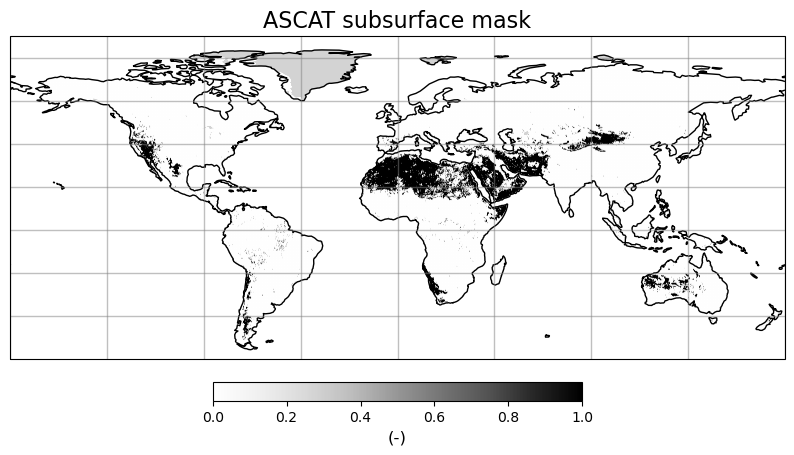

In [57]:
# Load alternative mask file
ds = xr.open_dataset('../test_data/clsm/subsurface_scattering_ASCAT_ERA5_Land.nc')

cold_mask = ds['cold_mask']
wet_mask = ds['wet_mask']
veg_mask = ds['veg_mask']
subsurface_mask = ds['subsurface_mask']
asc_lon = ds['lon']
asc_lat = ds['lat']

# Create a regular grid
lon = np.arange(-180, 180, 0.1)
lat = np.arange(-90, 90, 0.1)
maskp1 = np.empty([len(lat), len(lon)])
maskp1.fill(np.nan)

loncnt = np.empty(len(lon)*len(lat))
latcnt = np.empty(len(lon)*len(lat))
maskcnt = np.empty(len(lon)*len(lat))
maskcnt.fill(np.nan)
cnt = 0

# Loop through the regular grid and assign the mask value. Use the nearest neighbour method with xarray
for i in range(len(lon)):
    # Print lon[i] to see progress if lon[i] is a multiple of 10
    print(lon[i])
    for j in range(len(lat)):
        
        distances = np.sqrt((asc_lon - lon[i])**2 + (asc_lat - lat[j])**2)
        closest_index = distances.argmin()
        # If distances at closest_index is more than 0.5 degrees, then the nearest neighbour is too far away so set to nan
        if distances[closest_index] > 0.14:
            maskp1[j, i] = np.nan
        else:
            maskp1[j, i] = subsurface_mask[closest_index]

        loncnt[cnt] = lon[i]
        latcnt[cnt] = lat[j]
        maskcnt[cnt] = maskp1[j, i]

        cnt += 1

# Save the mask to a npz file
np.savez('ascat_subsurface_mask_point1.npz', lon=lon, lat=lat, maskp1=maskp1)

# Plot the mask
plot_array = np.empty([len(loncnt), 3])
plot_array.fill(np.nan)
plot_array[:, 1] = loncnt
plot_array[:, 2] = latcnt
plot_array[:, 0] = maskcnt

plot_global_tight(plot_array,False,'ASCAT subsurface mask','(-)', 0, 1, cmap='Greys')

In [59]:
mask_out = np.where(np.isnan(maskp1), -128, maskp1)
mask_out = mask_out.astype(np.int8)
# mask_out = mask

ds = xr.Dataset({'mask': (['lat', 'lon'], mask_out)},
                coords={'lat': (['lat'], lat),
                        'lon': (['lon'], lon)})

# Add attributes to the 'mask' variable
ds['mask'].attrs['standard_name'] = 'subsurface_mask'
ds['mask'].attrs['long_name'] = 'Mask accounting for subsurface scattering'
ds['mask'].attrs['units'] = 'boolean'
ds['mask'].encoding['_FillValue'] = -128

ds.to_netcdf('ascat_subsurface_mask_p1.nc')

ll_lon = -180  # Lower left corner longitude

# Create a new DataArray for ll_lon
ll_lon_da = xr.DataArray(ll_lon, name='ll_lon')
ll_lon_da.attrs['standard_name'] = 'longitude of lower left corner'
ll_lon_da.attrs['long_name'] = 'longitude of lower left corner'
ll_lon_da.attrs['units'] = 'degrees_east'
ll_lon_da.attrs['axis'] = 'X'

# Add ll_lon_da to the dataset
ds['ll_lon'] = ll_lon_da

# Write the dataset to a netCDF file
ds.to_netcdf('ascat_subsurface_mask_p1.nc')

# Repeat for ll_lat
ll_lat = -90  # Lower left corner latitude
ll_lat_da = xr.DataArray(ll_lat, name='ll_lat')
ll_lat_da.attrs['standard_name'] = 'latitude of lower left corner'
ll_lat_da.attrs['long_name'] = 'latitude of lower left corner'
ll_lat_da.attrs['units'] = 'degrees_north'
ll_lat_da.attrs['axis'] = 'Y'

ds['ll_lat'] = ll_lat_da

ds.to_netcdf('ascat_subsurface_mask_p1.nc')

dlon = 0.1  # Longitude grid spacing

# Create a new DataArray for dlon
dlon_da = xr.DataArray(dlon, name='d_lon')
dlon_da.attrs['standard_name'] = 'longitude grid spacing'
dlon_da.attrs['long_name'] = 'longitude grid spacing'
dlon_da.attrs['units'] = 'degrees'
dlon_da.attrs['axis'] = 'X'

# Add dlon_da to the dataset
ds['d_lon'] = dlon_da

# Write the dataset to a netCDF file
ds.to_netcdf('ascat_subsurface_mask_p1.nc')

# Repeat for dlat
dlat = 0.1  # Latitude grid spacing
dlat_da = xr.DataArray(dlat, name='d_lat')
dlat_da.attrs['standard_name'] = 'latitude grid spacing'
dlat_da.attrs['long_name'] = 'latitude grid spacing'
dlat_da.attrs['units'] = 'degrees'
dlat_da.attrs['axis'] = 'Y'

ds['d_lat'] = dlat_da

ds.to_netcdf('ascat_subsurface_mask_p1.nc')